{{title_s1_1_1}}

{{intro}}

Read Sentinel-1 RTC data processed by ASF using GDAL VRT approach

This notebook demonstrates working with Sentinel-1 RTC imagery that has been processed on the [ASF On-Demand server](https://docs.asf.alaska.edu/vertex/manual/) and downloaded locally. 

The access point for data in this notebook is a directory containing un-zipped directories of RTC scenes.

{{outline}}

### A. Setup
- Read auxiliary vector data and define helper functions
### B. Organize S1 data to create VRTs
### C. Create VRTs
### D. Extract metadata
### E. Clip by vector data
### F. Merge metadata
### G. Handle nodata
### H. Visualize data

{{learning_goals}}

{{concepts}}
- Organize large set of geotiff files stored locally
- Use VRT objects to create xarray objects from large data stacks
- Extract and organize metadata stored in filenames and text files
- Handle `nodata` values 

{{techniques}}
- Build gdal VRT objects
- Read in data using `rioxarray.open_rasterio()`
- Clip raster object by a vector using `rioxarray.clip()`
- Indexing and selecting xarray objects by dimensional and non-dimensional coordinates
- Formatting time-aware xarray objects

:::{admonition} ASF Data Access
You can download the RTC-processed backscatter time series [here](https://zenodo.org/record/7236413#.Y1rNi37MJ-0)
:::

Expand the next cell to see specific packages used in this notebook and relevant system and version information.

In [1]:
%xmode minimal
import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask
import markdown
import pathlib
from pathlib import Path
import time
import glob


Exception reporting mode: Minimal


## Setup

### {{a1_s1_nb1}}
We'll also want to run some common operations several times; to make this easier we write them as functions to call later

In [2]:
#use this function to get bounding box coordinates from a list of points 
def points2coords(pt_ls:list) -> list: #should be [xmin, ymin, xmax, ymax]
    
    coords_ls = [(pt_ls[0], pt_ls[1]), (pt_ls[0], pt_ls[3]),
                 (pt_ls[2], pt_ls[3]), (pt_ls[2], pt_ls[1]),
                 (pt_ls[0], pt_ls[1])]
    return coords_ls
    



In [3]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

### {{a2_s1_nb1}}

Later in this notebook we will want to use vector data to help subset the raster data cube of Sentinel-1 imagery, read it into memory as a `geopandas.GeoDataFrame` object below. It is called PC aoi because the GeoJSON file was created off of the spatial extent of the SAR data we will access from Microsoft Planetary Computer (PC), in order to have comparable datasets.


In [4]:
pc_aoi = gpd.read_file('https://github.com/e-marshall/sentinel1_rtc/raw/main/hma_rtc_aoi.geojson')
pc_aoi

,geometry
0,"POLYGON ((619420 3089790, 628100 3089790, 6281..."


### Organizing Sentinel-1 data to create VRT objects. 

Setup string variables to access filenames + filepaths. Currently, the file structure is organized so that each scene has its own sub-directory within `asf_rtcs`. Within each sub-directory are several files - we want to extract the tif files containing RTC imagery for the VV and VH polarizations for each scene.

The function `extract_tif_fnames()` takes a path to the directory containing the sub-directories for all scenes and returns a lists of filenames for VV polarization GeoTIFF files, VH polarization GeoTIFF files and the layover-shadow mask GeoTIFF files. Separately, it returns a list of filenames for the associated README files which will be used to extract metadata later on. 

```{note}
If you're following along in your own python environment, replace the string below named `dir_path_all` with the path to the directory containing the RTC data on your local machine, then execute `extract_tif_fnames()`. 
```

In [5]:
dir_path_all = '/home/emmamarshall/Desktop/phd_research/ch1/sentinel1_rtc/data/asf_rtcs/'
scenes_ls = os.listdir(dir_path_all)

def extract_tif_fnames(scene_path):
    ''' return a list of files associated with a single S1 scene'''
    scene_files_ls = os.listdir(os.path.join(dir_path_all,scene_path))
        
    #make object for readme file
    rm = [file for file in scene_files_ls if file.endswith('README.md.txt')]
    
    scene_files_vh = [fname for fname in scene_files_ls if fname.endswith('_VH.tif')]
    scene_files_vv = [fname for fname in scene_files_ls if fname.endswith('_VV.tif')]
    scene_files_ls = [fname for fname in scene_files_ls if fname.endswith('_ls_map.tif')]
    
    return scene_files_vv, scene_files_vh, scene_files_ls, rm

Every scene will have the following four elements:  
    - VH band [type: GeoTIFF]  
    - VV band [type: GeoTIFF]  
    - Layover-shadow map [type: GeoTIFF]   
    - README [type: txt]  

In [6]:
extract_tif_fnames(scenes_ls[0])

(['S1A_IW_20220403T121353_DVP_RTC30_G_gpuned_3C39_VV.tif'],
 ['S1A_IW_20220403T121353_DVP_RTC30_G_gpuned_3C39_VH.tif'],
 ['S1A_IW_20220403T121353_DVP_RTC30_G_gpuned_3C39_ls_map.tif'],
 ['S1A_IW_20220403T121353_DVP_RTC30_G_gpuned_3C39.README.md.txt'])

We need to attach the filenames to the full path to each file so that we end up with a list of the full paths to the VV and VH band imagery, layover-shadow maps and README files. 

In [7]:
fpaths_vv, fpaths_vh, fpaths_ls, fpaths_rm = [],[],[], []

for element in range(len(scenes_ls)):
    
    files_of_interest = extract_tif_fnames(scenes_ls[element])

    path_vh = os.path.join(dir_path_all, scenes_ls[element], files_of_interest[0][0])
    path_vv = os.path.join(dir_path_all, scenes_ls[element], files_of_interest[1][0])
    path_ls = os.path.join(dir_path_all, scenes_ls[element], files_of_interest[2][0])
    path_readme = os.path.join(dir_path_all, scenes_ls[element], files_of_interest[3][0])
    
    #path_vh = dir_path_all + scenes_ls[element] + '/' + good_files[0][0]
    #path_vv = dir_path_all + scenes_ls[element] + '/' + good_files[1][0]
    #path_ls = dir_path_all + scenes_ls[element] + '/' + good_files[2][0]
    #path_readme = dir_path_all + scenes_ls[element] + '/' + good_files[3][0]
    
    fpaths_vv.append(path_vv)
    fpaths_vh.append(path_vh)
    fpaths_ls.append(path_ls)
    fpaths_rm.append(path_readme)

In [8]:
assert len(fpaths_vv) == len(fpaths_vh) == len(fpaths_ls) == len(fpaths_rm), "Files weren't extracted correctly or fname lists weren't made correctly"

In [9]:
fpaths_dict = {
    'vv': fpaths_vv,
    'vh': fpaths_vh,
    'ls': fpaths_ls,
    'readme': fpaths_rm
}

## Create VRT objects

We will be using the `gdalbuildvrt` command. You can find out more about it [here](https://manpages.ubuntu.com/manpages/bionic/man1/gdalbuildvrt.1.html). This command can make a VRT that either tiles the listed files into a large mosaic, or places them each in a separate band of the VRT. Because we are dealing with a temporal stack of images we want to use the `-separate` flag to place each file into a band of the VRT. </br>
Because we are making a VRT from a large number of files, we'll supply a text file with the full path for each file rather than include these at the end of the command line. We'll use the same lists of filepaths that we constructed above and will write them to text files that we pass to the `gdalbuildvrt` command.

```{note}
If you are following along on your machine, be sure to replace the file paths in the below cell with the location where you would like the text files to be written.
```

In [12]:
def create_vrt_objects(vrt_path:str, fpaths_dict:dict):

    #VV
    vv_fpath_input_txt = os.path.join(vrt_path, 's1_vv_fpaths.txt')
    vv_output_vrt = '../data/tutorial2/vrt_files/s1_stackVV.vrt'

    with open(vv_fpath_input_txt,'w') as fp:
        for item in fpaths_dict['vv']:
            fp.write(f'{item}\n')

    # VH
    vh_fpath_input_txt = os.path.join(vrt_path, 's1_vh_fpaths.txt')
    vh_output_vrt = '../data/tutorial2/vrt_files/s1_stackVH.vrt'

    with open(vh_fpath_input_txt,'w') as fp:
        for item in fpaths_dict['vh']:
            fp.write(f'{item}\n')

    # LS
    ls_fpath_input_txt = os.path.join(vrt_path, 's1_ls_fpaths.txt')
    ls_output_vrt = '../data/tutorial2/vrt_files/s1_stackLS.vrt'

    with open(ls_fpath_input_txt,'w') as fp:
        for item in fpaths_dict['ls']:
            fp.write(f'{item}\n')

    #Now create VRT files
    # syntax for gdalbuildvrt
    #`gdalbuildvrt -separate -input_file_list /path/to/my_list.txt vrt_fname.vrt` </br>

    # commands used to creat vrt files
    !gdalbuildvrt -separate -input_file_list {vv_fpath_input_txt} {vv_output_vrt}
    !gdalbuildvrt -separate -input_file_list {vh_fpath_input_txt} {vh_output_vrt}
    !gdalbuildvrt -separate -input_file_list {ls_fpath_input_txt} {ls_output_vrt}




In [14]:
%xmode verbose
create_vrt_objects('/home/emmamarshall/Desktop/phd_research/ch1/JOSE_tutorials_submission/book/data/tutorial2', fpaths_dict)

Exception reporting mode: Verbose
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


Next, we will use gdal command line tools to create the VRT objects:


```{note}
If you are following along on your machine, be sure to replace the file paths in the below cell with the location of the .txt files written in the step above.
```

Read in the VRT files using `rioxarray.open_rasterio()`:

In [15]:
vrt_vv = rio.open_rasterio('../data/tutorial2/vrt_files/s1_stackVV.vrt', chunks='auto').squeeze()
vrt_vh = rio.open_rasterio('../data/tutorial2/vrt_files/s1_stackVH.vrt', chunks='auto').squeeze()
vrt_ls = rio.open_rasterio('../data/tutorial2/vrt_files/s1_stackLS.vrt', chunks='auto').squeeze()

In [13]:
vrt_vv

<xarray.DataArray (band: 103, y: 13379, x: 17452)> Size: 96GB
dask.array<open_rasterio-34ca1657fb36d4c14b2adbdcebb92a82<this-array>, shape=(103, 13379, 17452), dtype=float32, chunksize=(1, 5760, 5760), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 824B 1 2 3 4 5 6 7 8 ... 97 98 99 100 101 102 103
  * x            (x) float64 140kB 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 107kB 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Building the `VRT` object assigns every object in the .txt file to a different band. In doing this, we lose the metadata that is associated with the files. We need to extract metadata from the file name and attach it to the xarray objects that we read in from VRTs.

## Extract metadata

The following function is very similar to the `preprocess()` function that is passed when calling `xr.open_mfdataset()`. There is an  example of this in the [appendix notebook](asf_local_mf.ipynb). It extracts metadata contained in the filename and organizes it as a dictionary that can be attached to an xarray object.

In [16]:
import re

def parse_fname_metadata(input_fname: str) -> dict:

    """Function to extract information from filename and separate into expected variables based on a defined schema."""
    #Define schema
    schema = {
        'sensor': (3, r"S1[A-B]"), #schema for sensor
        'beam_mode': (2, r"[A-Z]{2}"), #schema for beam mode
        'acq_date': (15, r"[0-9]{8}T[0-9]{6}"), #schema for acquisition date
        'pol_orbit': (3, r"[A-Z]{3}"), #schema for polarization + orbit type
        'terrain_correction_pixel_spacing': (5, r"RTC[0-9]{2}"), #schema for terrain correction pixel spacing
        'processing_software': (1, r"[A-Z]{1}"), #schema for processing software (G = Gamma)
        'output_info': (6, r"[a-z]{6}"), #schema for output info
        'product_id': (4, r"[A-Z0-9]{4}"), #schema for product id
        'prod_type': ((2,6), (r"[A-Z]{2}", r"ls_map")), #schema for polarization type
            }
    
    #Remove prefixs
    input_fname = input_fname.split('/')[-1]
    #Remove file extension if present
    input_fname = input_fname.removesuffix('.tif')
    #Split filename string into parts
    parts = input_fname.split('_')

    #l-s map objects have an extra '_' in the filename. Remove/combine parts so that it matches schema 
    if parts[-1] == 'map':

        parts = parts[:-1]
        parts[-1] = parts[-1] + '_map'
        
    #Check that number of parts matches expected schema
    if len(parts) != len(schema):
        raise ValueError(f'Input filename does not match schema of expected format: {parts}')
    
    #Create dict to store parsed data
    parsed_data = {}
    
    #Iterate through parts and schema    
    for (part, (name, (length_options, pattern_options))) in zip(parts, schema.items()):

        # In the schema we defined, items have an int for length or a tuple (when there is more than one possible lenght)
        # Make the int lengths into tuples 
        if isinstance(length_options, int):
            length_options = (length_options,)
        # Same as above for patterns
        if isinstance(pattern_options, str):
            pattern_options = (pattern_options,)
        
        #Check that each length of each part matches expected length from schema
        if len(part) not in length_options:
            raise ValueError(f'Part {part} does not have expected length {len(part)}')
        #Check that each part matches expected pattern from schema
        if not any(re.fullmatch(pattern, part) for pattern in pattern_options):
            raise ValueError(f'Part {part} does not match expected patterns {pattern_options}')

        #Special handling of a part (pol orbit) that has 3 types of metadata
        if name == 'pol_orbit':
     
            parsed_data.update({
                'polarization_type': part[:1], #Single (S) or Dual (D) pol
                'primary_polarization': part[1:2], #Primary polarization (H or V)
                'orbit_type': part[-1], #Precise (p), Restituted (r) or Original predicted (o)
            })
        #Format string acquisition date as a datetime time stamp
        elif name == 'acq_date':
            parsed_data[name] = pd.to_datetime(part, format='%Y%m%dT%H%M%S')
        #Expand multiple variables stored in output_info string part
        elif name == 'output_info':

            output_info_keys = ['output_type', 'output_unit', 'unmasked_or_watermasked',
                                'notfiltered_or_filtered', 'area_or_clipped', 'deadreckoning_or_demmatch']
            
            output_info_values = [part[0], part[1], part[2], part[3], part[4], part[-1]]

            parsed_data.update(dict(zip(output_info_keys, output_info_values)))

        else:
            parsed_data[name] = part

    return parsed_data



The acquisition dates extracted from the VV, VH and L-S geotiff files should be identical, but we read in all three here just to confirm:

In [17]:
acq_dates_vh = [parse_fname_metadata(fpaths_vh[file])['acq_date'].strftime('%m/%d/%YT%H%M%S') for file in range(len(fpaths_vh))]
acq_dates_vv = [parse_fname_metadata(fpaths_vv[file])['acq_date'].strftime('%m/%d/%YT%H%M%S') for file in range(len(fpaths_vv))]
acq_dates_ls = [parse_fname_metadata(fpaths_ls[file])['acq_date'].strftime('%m/%d/%YT%H%M%S') for file in range(len(fpaths_ls))]


In [18]:
acq_dates_vh[:5]

['04/03/2022T121353',
 '04/06/2022T000312',
 '03/10/2022T121353',
 '01/24/2022T000312',
 '04/30/2022T000313']

The acquisition dates for VV, VH and LS **should be** the same. As a check, you can confirm this by creating both objects and comparing them.

In [19]:
assert acq_dates_vh == acq_dates_vv == acq_dates_ls, 'Acquisition dates lists for VH, VV and L-S Map do not match'

We can now assign the list of acquisition dates as coordinates to the xarray objects. Use `pd.to_datetime()` to do this as time-aware coordinate values.

In [20]:
vrt_vv = vrt_vv.assign_coords({'band':pd.to_datetime(acq_dates_vv, format='%m/%d/%YT%H%M%S')})
vrt_vh = vrt_vh.assign_coords({'band':pd.to_datetime(acq_dates_vh, format='%m/%d/%YT%H%M%S')})
vrt_ls = vrt_ls.assign_coords({'band':pd.to_datetime(acq_dates_ls, format='%m/%d/%YT%H%M%S')})

Merge the three `xr.DataArrays` together into an `xr.Dataset`.

In [21]:
vrt_merge = xr.Dataset({'vv':vrt_vv, 
                      'vh':vrt_vh,
                       'ls':vrt_ls}).rename({'band':'acq_date'})

In [22]:
vrt_merge

<xarray.Dataset> Size: 216GB
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 140kB 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 107kB 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 8B 0
  * acq_date     (acq_date) datetime64[ns] 824B 2022-04-03T12:13:53 ... 2022-...
Data variables:
    vv           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    vh           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    ls           (acq_date, y, x) uint8 24GB dask.array<chunksize=(1, 11520, 11520), meta=np.ndarray>

The files are not organized by time in the directory, so the files are not read in in temporal order when we create the VRT and `xr.Dataset` objects. Once we have attached the temporal metadata to the xarray objects composed from VRT, we can use `Dataset.sortby()` to organize the dataset along time time dimension:

In [23]:
vrt_merge = vrt_merge.sortby(vrt_merge.acq_date)
vrt_merge

<xarray.Dataset> Size: 216GB
Dimensions:      (x: 17452, y: 13379, acq_date: 103)
Coordinates:
  * x            (x) float64 140kB 3.833e+05 3.833e+05 ... 9.068e+05 9.068e+05
  * y            (y) float64 107kB 3.309e+06 3.309e+06 ... 2.907e+06 2.907e+06
    spatial_ref  int64 8B 0
  * acq_date     (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022-...
Data variables:
    vv           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    vh           (acq_date, y, x) float32 96GB dask.array<chunksize=(1, 5760, 5760), meta=np.ndarray>
    ls           (acq_date, y, x) uint8 24GB dask.array<chunksize=(1, 11520, 11520), meta=np.ndarray>

### Taking a look at chunking

If you take a look at the chunking you will see that the entire object has a shape `(103, 13379, 17452)` and that each chunk is `(1, 5760, 5760)`. This breaks the full array (~ 89 GB) into 1,236 chunks that are about 127 MB each. We can also see that chunking keeps each time step intact which is optimal for time series data. If you are interested in an example of inefficient chunking, you can check out the example notebook in the [appendix](https://e-marshall.github.io/sentinel1_rtc/asf_local_mf.html#an-example-of-complicated-chunking). In this case, because of the internal structure of the data and the characteristics of the time series stack, various chunking strategies produced either too few (103) or too many (317,240) chunks with complicated structures that led to memory blow-ups when trying to compute. The difficulty we encountered trying to structure the data using `xr.open_mfdataset()` led us to use the VRT approach in this notebook but `xr.open_mfdataset()` is still a very useful tool if your data is a good fit. 

Chunking is an important aspect of how dask works. You want the chunking strategy to match the structure of the data (ie. internal tiling of the data, if your data is stored locally you want chunks to match the storage structure) without having too many chunks (this will cause unnecessary communication among workers) or too few chunks (this will lead to large chunk sizes and slower processing). There are helpful explanations [here](https://docs.dask.org/en/stable/array-best-practices.html#select-a-good-chunk-size) and [here](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes).
When chunking is set to `auto` (the case here), the optimal chunk size will be selected for each dimension (if specified individually) or all dimensions. Read more about chunking [here](https://docs.dask.org/en/stable/array-chunks.html).

### Clip by vector data

Clip the full object by the same AOI as above. We will use the [`rioxarray.clip()` method](https://corteva.github.io/rioxarray/stable/examples/clip_geom.html).

In [24]:
vrt_clip = vrt_merge.rio.clip(pc_aoi.geometry, pc_aoi.crs)
vrt_clip

<xarray.Dataset> Size: 106MB
Dimensions:      (x: 290, y: 396, acq_date: 103)
Coordinates:
  * x            (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y            (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
  * acq_date     (acq_date) datetime64[ns] 824B 2021-05-02T12:14:14 ... 2022-...
    spatial_ref  int64 8B 0
Data variables:
    vv           (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh           (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls           (acq_date, y, x) uint8 12MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

## Merge metadata

We had important metadata stored in the individual filenames of each Sentinel-1 scene that was dropped when we converted them to VRT objects. Let's use the original filenames to extract the metadata and assign the data as coordinates of our formatted xarray object.

First here is what the metadata looks like for a single file

In [25]:
parse_fname_metadata(fpaths_vv[0])

{'sensor': 'S1A',
 'beam_mode': 'IW',
 'acq_date': Timestamp('2022-04-03 12:13:53'),
 'polarization_type': 'D',
 'primary_polarization': 'V',
 'orbit_type': 'P',
 'terrain_correction_pixel_spacing': 'RTC30',
 'processing_software': 'G',
 'output_type': 'g',
 'output_unit': 'p',
 'unmasked_or_watermasked': 'u',
 'notfiltered_or_filtered': 'n',
 'area_or_clipped': 'e',
 'deadreckoning_or_demmatch': 'd',
 'product_id': '3C39',
 'prod_type': 'VH'}

In [26]:
meta_attrs_ls_vv = [parse_fname_metadata(fpaths_vv[file]) for file in range(len(fpaths_vv))]

In [27]:
def stacked_meta_tuple(input_ls):
    '''takes a list of dictionaries where each dict is metadata for a given time step,
    returns a tuple. input list is re-organized to a tuple where each [0] values is a metadata category (ie. sensor) and 
    [1] is a time series of the categories values over time (ie. S1A, S1A, S1A ...)'''
    
    meta_dict = input_ls[0]
    ticker = 0
    attrs_dicts, keys_ls = [],[]
    
    for key in meta_dict:
        if key == 'acq_date': 
            pass
        else:
            
            key_dict = {f'{key}':[input_ls[ticker][key] for ticker in range(len(input_ls))]}
            ticker+=1
            attrs_dicts.append(key_dict)
            keys_ls.append(key)
    
    full_tuple = tuple(zip(keys_ls, attrs_dicts))
    
    return full_tuple

In [28]:
def apply_meta_coords(input_xr, input_tuple):
    '''takes an input xarray object and a tuple of metadata created from the above fn.
    returns xr object with metadata from tuple applied
    '''
    
    out_xr = xr.Dataset(
        input_xr.data_vars,
        coords = {'x': input_xr.x.data,
                  'y': input_xr.y.data,
        #          'acq_date': input_xr.acq_date.data,
                 }
    )
    # now apply metadata coords 
    for element in range(len(input_tuple)):
        key = input_tuple[element][0]
        coord = list(input_tuple[element][1].values())[0]
        out_xr.coords[f'{key}'] = ('acq_date', coord)

        
    return out_xr

In [29]:
meta_tuple = stacked_meta_tuple(meta_attrs_ls_vv)

In [30]:
vrt_full = apply_meta_coords(vrt_clip, meta_tuple)

In [31]:
vrt_full

<xarray.Dataset> Size: 106MB
Dimensions:                           (x: 290, y: 396, acq_date: 103)
Coordinates: (12/19)
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
  * acq_date                          (acq_date) datetime64[ns] 824B 2021-05-...
    spatial_ref                       int64 8B 0
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    beam_mode                         (acq_date) <U2 824B 'IW' 'IW' ... 'IW'
    ...                                ...
    unmasked_or_watermasked           (acq_date) <U1 412B 'u' 'u' ... 'u' 'u'
    notfiltered_or_filtered           (acq_date) <U1 412B 'n' 'n' ... 'n' 'n'
    area_or_clipped                   (acq_date) <U1 412B 'e' 'e' ... 'e' 'e'
    deadreckoning_or_demmatch         (acq_date) <U1 412B 'd' 'd' ... 'd' 'd'
    product_id                        (acq_date) <U4 2kB '3C39' ... '5844'
    prod_type                         (acq_date) <U2 824B 'VH' 'VH' ... 'VH'
Data variables:
    vv                                (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) uint8 12MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

### Add granule ID as another non-dimensional coordinate

#### Extract SLC granule ID from readme

The original granule ID associated with the Sentinel-1 data product published by the European Space Agency contains metadata that it would be helpful for us to attach to our xarray objects. The README file that is associated with every scene contains the source granule used to generate that product. 

The following two functions will be used to extract the source granule ID from each README file then to attach the ID as a coordinate to the xarray object containing the SAR imagery.
Using the `granule_da` object created earlier

In [32]:
def extract_granule_id(filepath):
    ''' takes a filepath to the readme associated with an S1 scene and returns the source granule id used to generate the RTC imagery''' 

    md = markdown.Markdown(extensions=['meta'])
    data = pathlib.Path(filepath).read_text()
    #this text precedes granule ID in readme
    gran_str = 'The source granule used to generate the products contained in this folder is:\n'
    split = data.split(gran_str)
    #isolate the granule id
    gran_id = split[1][:67]
    
    return gran_id

#### Construct granule ID coordinate

In [33]:
def make_granule_coord(readme_fpaths_ls):
    '''takes a list of the filepaths to every read me, extracts the granule ID, 
    extracts acq date for each granule ID, organizes this as an array that
    can be assigned as a coord to an xarray object'''
    
    granule_ls = [extract_granule_id(readme_fpaths_ls[element]) for element in range(len(readme_fpaths_ls))]
    acq_date = [pd.to_datetime(granule[17:25]) for granule in granule_ls]
    granule_da = xr.DataArray(data = granule_ls, 
                              dims = ['acq_date'],
                              coords = {'acq_date':acq_date},
                              attrs = {'description': 'source granule ID for ASF-processed S1 RTC imagery, extracted from README files for each scene'},
                              name = 'granule_id')
    granule_da = granule_da.sortby(granule_da.acq_date)
    
    return granule_da

The object below (`granule_da`) is a 2-dimensional `xr.DataArray` that contains an acquisition date coordinate dimension and an array of Sentinel-1 granule IDs. It will be used later when we are merging metadata with our imagery object.


In [34]:
granule_da = make_granule_coord(fpaths_rm)

In [67]:
granule_da

<xarray.DataArray 'granule_id' (acq_date: 103)> Size: 28kB
array(['S1A_IW_SLC__1SDV_20210502T121414_20210502T121441_037709_047321_900F',
       'S1A_IW_SLC__1SDV_20210505T000307_20210505T000334_037745_047463_4DEF',
       'S1A_IW_SLC__1SDV_20210509T120542_20210509T120609_037811_047676_9EBD',
       'S1A_IW_SLC__1SDV_20210514T121349_20210514T121416_037884_047898_4702',
       'S1A_IW_SLC__1SDV_20210514T121414_20210514T121442_037884_047898_FE6F',
       'S1A_IW_SLC__1SDV_20210517T000308_20210517T000335_037920_0479A9_2A18',
       'S1A_IW_SLC__1SDV_20210521T120543_20210521T120609_037986_047BBD_1CA0',
       'S1A_IW_SLC__1SDV_20210526T121350_20210526T121417_038059_047DE5_0E67',
       'S1A_IW_SLC__1SDV_20210529T000309_20210529T000336_038095_047EF4_5449',
       'S1A_IW_SLC__1SDV_20210602T120543_20210602T120610_038161_0480FD_893F',
       'S1A_IW_SLC__1SDV_20210607T121351_20210607T121418_038234_048318_9B64',
       'S1A_IW_SLC__1SDV_20210610T000310_20210610T000337_038270_04841E_601A',
       'S1A_IW_SLC__1SDV_20210614T120544_20210614T120611_038336_04862F_337B',
       'S1A_IW_SLC__1SDV_20210619T121352_20210619T121419_038409_04884C_1DBA',
       'S1A_IW_SLC__1SDV_20210622T000310_20210622T000337_038445_04895A_842E',
       'S1A_IW_SLC__1SDV_20210626T120545_20210626T120612_038511_048B6C_9585',
       'S1A_IW_SLC__1SDV_20210701T121417_20210701T121445_038584_048D87_C79E',
       'S1A_IW_SLC__1SDV_20210701T121352_20210701T121419_038584_048D87_F95C',
       'S1A_IW_SLC__1SDV_20210704T000311_20210704T000338_038620_048E99_1BAA',
       'S1A_IW_SLC__1SDV_20210708T120545_20210708T120612_038686_0490AD_DD9E',
...
       'S1A_IW_SLC__1SDV_20220317T120545_20220317T120612_042361_050CE5_4CCF',
       'S1A_IW_SLC__1SDV_20220322T121353_20220322T121420_042434_050F59_A1B6',
       'S1A_IW_SLC__1SDV_20220325T000312_20220325T000339_042470_051096_BA6F',
       'S1A_IW_SLC__1SDV_20220329T120546_20220329T120613_042536_0512D7_425A',
       'S1A_IW_SLC__1SDV_20220403T121353_20220403T121420_042609_05154A_3FE7',
       'S1A_IW_SLC__1SDV_20220403T121418_20220403T121446_042609_05154A_51E7',
       'S1A_IW_SLC__1SDV_20220406T000312_20220406T000339_042645_051682_4B40',
       'S1A_IW_SLC__1SDV_20220410T120546_20220410T120613_042711_0518C0_3349',
       'S1A_IW_SLC__1SDV_20220415T121353_20220415T121420_042784_051B30_EB87',
       'S1A_IW_SLC__1SDV_20220418T000312_20220418T000339_042820_051C63_CAB2',
       'S1A_IW_SLC__1SDV_20220422T120547_20220422T120614_042886_051E96_41EE',
       'S1A_IW_SLC__1SDV_20220427T121354_20220427T121421_042959_0520EE_A42D',
       'S1A_IW_SLC__1SDV_20220430T000313_20220430T000340_042995_05221E_46A1',
       'S1A_IW_SLC__1SDV_20220504T120547_20220504T120614_043061_05245F_6F62',
       'S1A_IW_SLC__1SDV_20220509T121355_20220509T121422_043134_0526C4_092E',
       'S1A_IW_SLC__1SDV_20220516T120548_20220516T120615_043236_0529DD_42D2',
       'S1A_IW_SLC__1SDV_20220521T121356_20220521T121423_043309_052C00_FE88',
       'S1A_IW_SLC__1SDV_20220521T121420_20220521T121448_043309_052C00_493D',
       'S1A_IW_SLC__1SDV_20220521T121420_20220521T121448_043309_052C00_493D'],
      dtype='<U67')
Coordinates:
  * acq_date  (acq_date) datetime64[ns] 824B 2021-05-02 ... 2022-05-21
Attributes:
    description:  source granule ID for ASF-processed S1 RTC imagery, extract...

Each line above is the full granule ID for the Sentinel-1 acquisition from 6/2/2021. You can read about the Sentinel-1 file naming convention [here](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-1-sar/naming-conventions), but for now we are interested in the 6-digit mission data take ID. 

Example from the first line of `granule_da`:

`S1A_IW_SLC__1SDV_20210502T121414_20210502T121441_037709_047321_900F`

The acquisition date for this image was `05/02/2021` and the mission data take ID is `047321`.

In [35]:
vrt_full.coords["granule_id"] = ('acq_date', granule_da.data)

In [36]:
vrt_full.granule_id

<xarray.DataArray 'granule_id' (acq_date: 103)> Size: 28kB
array(['S1A_IW_SLC__1SDV_20210502T121414_20210502T121441_037709_047321_900F',
       'S1A_IW_SLC__1SDV_20210505T000307_20210505T000334_037745_047463_4DEF',
       'S1A_IW_SLC__1SDV_20210509T120542_20210509T120609_037811_047676_9EBD',
       'S1A_IW_SLC__1SDV_20210514T121349_20210514T121416_037884_047898_4702',
       'S1A_IW_SLC__1SDV_20210514T121414_20210514T121442_037884_047898_FE6F',
       'S1A_IW_SLC__1SDV_20210517T000308_20210517T000335_037920_0479A9_2A18',
       'S1A_IW_SLC__1SDV_20210521T120543_20210521T120609_037986_047BBD_1CA0',
       'S1A_IW_SLC__1SDV_20210526T121350_20210526T121417_038059_047DE5_0E67',
       'S1A_IW_SLC__1SDV_20210529T000309_20210529T000336_038095_047EF4_5449',
       'S1A_IW_SLC__1SDV_20210602T120543_20210602T120610_038161_0480FD_893F',
       'S1A_IW_SLC__1SDV_20210607T121351_20210607T121418_038234_048318_9B64',
       'S1A_IW_SLC__1SDV_20210610T000310_20210610T000337_038270_04841E_601A',
       'S1A_IW_SLC__1SDV_20210614T120544_20210614T120611_038336_04862F_337B',
       'S1A_IW_SLC__1SDV_20210619T121352_20210619T121419_038409_04884C_1DBA',
       'S1A_IW_SLC__1SDV_20210622T000310_20210622T000337_038445_04895A_842E',
       'S1A_IW_SLC__1SDV_20210626T120545_20210626T120612_038511_048B6C_9585',
       'S1A_IW_SLC__1SDV_20210701T121417_20210701T121445_038584_048D87_C79E',
       'S1A_IW_SLC__1SDV_20210701T121352_20210701T121419_038584_048D87_F95C',
       'S1A_IW_SLC__1SDV_20210704T000311_20210704T000338_038620_048E99_1BAA',
       'S1A_IW_SLC__1SDV_20210708T120545_20210708T120612_038686_0490AD_DD9E',
...
       'S1A_IW_SLC__1SDV_20220317T120545_20220317T120612_042361_050CE5_4CCF',
       'S1A_IW_SLC__1SDV_20220322T121353_20220322T121420_042434_050F59_A1B6',
       'S1A_IW_SLC__1SDV_20220325T000312_20220325T000339_042470_051096_BA6F',
       'S1A_IW_SLC__1SDV_20220329T120546_20220329T120613_042536_0512D7_425A',
       'S1A_IW_SLC__1SDV_20220403T121353_20220403T121420_042609_05154A_3FE7',
       'S1A_IW_SLC__1SDV_20220403T121418_20220403T121446_042609_05154A_51E7',
       'S1A_IW_SLC__1SDV_20220406T000312_20220406T000339_042645_051682_4B40',
       'S1A_IW_SLC__1SDV_20220410T120546_20220410T120613_042711_0518C0_3349',
       'S1A_IW_SLC__1SDV_20220415T121353_20220415T121420_042784_051B30_EB87',
       'S1A_IW_SLC__1SDV_20220418T000312_20220418T000339_042820_051C63_CAB2',
       'S1A_IW_SLC__1SDV_20220422T120547_20220422T120614_042886_051E96_41EE',
       'S1A_IW_SLC__1SDV_20220427T121354_20220427T121421_042959_0520EE_A42D',
       'S1A_IW_SLC__1SDV_20220430T000313_20220430T000340_042995_05221E_46A1',
       'S1A_IW_SLC__1SDV_20220504T120547_20220504T120614_043061_05245F_6F62',
       'S1A_IW_SLC__1SDV_20220509T121355_20220509T121422_043134_0526C4_092E',
       'S1A_IW_SLC__1SDV_20220516T120548_20220516T120615_043236_0529DD_42D2',
       'S1A_IW_SLC__1SDV_20220521T121356_20220521T121423_043309_052C00_FE88',
       'S1A_IW_SLC__1SDV_20220521T121420_20220521T121448_043309_052C00_493D',
       'S1A_IW_SLC__1SDV_20220521T121420_20220521T121448_043309_052C00_493D'],
      dtype='<U67')
Coordinates: (12/18)
  * acq_date                          (acq_date) datetime64[ns] 824B 2021-05-...
    spatial_ref                       int64 8B 0
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    beam_mode                         (acq_date) <U2 824B 'IW' 'IW' ... 'IW'
    polarization_type                 (acq_date) <U1 412B 'D' 'D' ... 'D' 'D'
    primary_polarization              (acq_date) <U1 412B 'V' 'V' ... 'V' 'V'
    ...                                ...
    notfiltered_or_filtered           (acq_date) <U1 412B 'n' 'n' ... 'n' 'n'
    area_or_clipped                   (acq_date) <U1 412B 'e' 'e' ... 'e' 'e'
    deadreckoning_or_demmatch         (acq_date) <U1 412B 'd' 'd' ... 'd' 'd'
    product_id                        (acq_date) <U4 2kB '3C39' ... '5844'
    prod_type                         (acq_date) <U2 824B '

## Add orbital direction coord

Next we want to add orbital direction as a coordinate to the xarray object. To do this we will: 

1. Use `acq_date.dt.hour` to segment acquisitions by orbital direction
2. Use `xarray.where()` to translate hour to "asc" or "desc" 
3. Assign coord for orbital pass


Check the `dt.hour` accessor of the `vrt_full.acquisition_time` data array to confirm that's what we want: 

In [37]:
vrt_full.isel(acq_date=0)

<xarray.Dataset> Size: 1MB
Dimensions:                           (x: 290, y: 396)
Coordinates: (12/20)
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
    acq_date                          datetime64[ns] 8B 2021-05-02T12:14:14
    spatial_ref                       int64 8B 0
    sensor                            <U3 12B 'S1A'
    beam_mode                         <U2 8B 'IW'
    ...                                ...
    notfiltered_or_filtered           <U1 4B 'n'
    area_or_clipped                   <U1 4B 'e'
    deadreckoning_or_demmatch         <U1 4B 'd'
    product_id                        <U4 16B '3C39'
    prod_type                         <U2 8B 'VH'
    granule_id                        <U67 268B 'S1A_IW_SLC__1SDV_20210502T12...
Data variables:
    vv                                (y, x) float32 459kB dask.array<chunksize=(396, 290), meta=np.ndarray>
    vh                                (y, x) float32 459kB dask.array<chunksize=(396, 290), meta=np.ndarray>
    ls                                (y, x) uint8 115kB dask.array<chunksize=(396, 290), meta=np.ndarray>

In [38]:
vrt_full.acq_date.dt.hour

<xarray.DataArray 'hour' (acq_date: 103)> Size: 824B
array([12,  0, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,
       12,  0, 12, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12,
       12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0,
       12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,
        0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12,
       12,  0, 12, 12, 12,  0, 12, 12,  0, 12, 12,  0, 12, 12, 12, 12, 12,
       12])
Coordinates: (12/18)
  * acq_date                          (acq_date) datetime64[ns] 824B 2021-05-...
    spatial_ref                       int64 8B 0
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    beam_mode                         (acq_date) <U2 824B 'IW' 'IW' ... 'IW'
    polarization_type                 (acq_date) <U1 412B 'D' 'D' ... 'D' 'D'
    primary_polarization              (acq_date) <U1 412B 'V' 'V' ... 'V' 'V'
    ...                                ...
    notfiltered_or_filtered           (acq_date) <U1 412B 'n' 'n' ... 'n' 'n'
    area_or_clipped                   (acq_date) <U1 412B 'e' 'e' ... 'e' 'e'
    deadreckoning_or_demmatch         (acq_date) <U1 412B 'd' 'd' ... 'd' 'd'
    product_id                        (acq_date) <U4 2kB '3C39' ... '5844'
    prod_type                         (acq_date) <U2 824B 'VH' 'VH' ... 'VH'
    granule_id                        (acq_date) <U67 28kB 'S1A_IW_SLC__1SDV_...

Assign the above object as a coordinate of `vrt_full`:

In [39]:
vrt_full.coords['orbital_dir'] = ('acq_date', xr.where(vrt_full.acq_date.dt.hour.data== 0, 'asc','desc'))

In [40]:
vrt_full

<xarray.Dataset> Size: 107MB
Dimensions:                           (x: 290, y: 396, acq_date: 103)
Coordinates: (12/21)
  * x                                 (x) float64 2kB 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3kB 3.102e+06 ... 3.09e+06
  * acq_date                          (acq_date) datetime64[ns] 824B 2021-05-...
    spatial_ref                       int64 8B 0
    sensor                            (acq_date) <U3 1kB 'S1A' 'S1A' ... 'S1A'
    beam_mode                         (acq_date) <U2 824B 'IW' 'IW' ... 'IW'
    ...                                ...
    area_or_clipped                   (acq_date) <U1 412B 'e' 'e' ... 'e' 'e'
    deadreckoning_or_demmatch         (acq_date) <U1 412B 'd' 'd' ... 'd' 'd'
    product_id                        (acq_date) <U4 2kB '3C39' ... '5844'
    prod_type                         (acq_date) <U2 824B 'VH' 'VH' ... 'VH'
    granule_id                        (acq_date) <U67 28kB 'S1A_IW_SLC__1SDV_...
    orbital_dir                       (acq_date) <U4 2kB 'desc' 'asc' ... 'desc'
Data variables:
    vv                                (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 47MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) uint8 12MB dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

## Handle nodata values

Another important difference between the `xr.open_mfdataset()` and VRT approaches is the handling of the nodata values. In the object built using `xr.open_mfdataset()`, nodata values are set to NaN while building the object from VRT files converts nodata values to zeros. This can cause a stream of problems later on so it is best to convert them to NaNs now. You can check the handling of nodata values in your dataset by using the `rio.nodata` accessor (shown below) which you can read about [here](https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html).

In [41]:
vrt_full.vv.isel(acq_date=0).rio.nodata

np.float32(0.0)

^ We want this to be a nan.

So using `xr.Dataset.where()` (don't think this will actually overwrite the official nodata value, but it should replace the zeros:

In [42]:
vrt_full =  vrt_full.where(vrt_full.vv != 0., np.nan, drop=False)

In [43]:
vrt_full.product_id.data

array(['3C39', 'BD36', '6E6F', 'F4B3', '5569', '6153', 'CFFC', 'E113',
       '57F2', 'F9A9', '71C9', 'CA1B', '5FF4', '250E', '3E89', '8CD8',
       'D35A', '1424', 'AA68', '832B', '528F', '3770', '8F7B', '3A2A',
       '22BD', '9849', '772E', '407D', '54B1', '971C', 'AC38', 'F5AA',
       'D4E6', '066E', 'F306', '68EA', '1139', '2CBE', '57E1', 'D846',
       '83D7', 'B409', '24B8', 'F587', '6581', '5BAD', 'B7B0', '8A4F',
       '378D', '199D', 'F1DE', '51E7', 'E61E', 'BB26', 'FD00', '6340',
       '5D96', 'C14C', '1DFD', '6270', '6683', '7418', 'F573', 'B942',
       'ED8C', '9331', '5F4E', 'FA4F', 'E5B6', 'B661', '1380', '0CAD',
       'BDC1', 'E74B', 'ABA0', '9A2F', '106F', 'C890', '81EB', 'DCE1',
       'D082', '01F4', '61B6', 'AA59', '33F5', '5413', '01B2', 'F0A6',
       'D049', '748F', '0535', 'D48F', '056C', 'BEAB', '0D1E', '65E0',
       '52BB', '485C', '0579', '6943', 'F7ED', '0031', '5844'],
      dtype='<U4')

In [44]:
vrt_full.granule_id.data

array(['S1A_IW_SLC__1SDV_20210502T121414_20210502T121441_037709_047321_900F',
       'S1A_IW_SLC__1SDV_20210505T000307_20210505T000334_037745_047463_4DEF',
       'S1A_IW_SLC__1SDV_20210509T120542_20210509T120609_037811_047676_9EBD',
       'S1A_IW_SLC__1SDV_20210514T121349_20210514T121416_037884_047898_4702',
       'S1A_IW_SLC__1SDV_20210514T121414_20210514T121442_037884_047898_FE6F',
       'S1A_IW_SLC__1SDV_20210517T000308_20210517T000335_037920_0479A9_2A18',
       'S1A_IW_SLC__1SDV_20210521T120543_20210521T120609_037986_047BBD_1CA0',
       'S1A_IW_SLC__1SDV_20210526T121350_20210526T121417_038059_047DE5_0E67',
       'S1A_IW_SLC__1SDV_20210529T000309_20210529T000336_038095_047EF4_5449',
       'S1A_IW_SLC__1SDV_20210602T120543_20210602T120610_038161_0480FD_893F',
       'S1A_IW_SLC__1SDV_20210607T121351_20210607T121418_038234_048318_9B64',
       'S1A_IW_SLC__1SDV_20210610T000310_20210610T000337_038270_04841E_601A',
       'S1A_IW_SLC__1SDV_20210614T120544_20210614T120611_038336_

## Quick visualization

Before we move on to the next notebook, let's take a quick look at the dataset. We will use the function defined earlier to convert the data from power scale to dB scale. This makes it easier to visualize variability in backscatter. Read more about SAR data scales [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#sar-scales).

First let's visualize backscatter variability over time. To do this, we will perform a reduction along the `x` and `y` dimensions of the dataset. We can use built-in xarray plotting methods to plot the 2-dimensional data (backscatter and time, after reducing along `x` and `y`)

(See the [Xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/plotting.html) for more on visualizing Xarray objects)

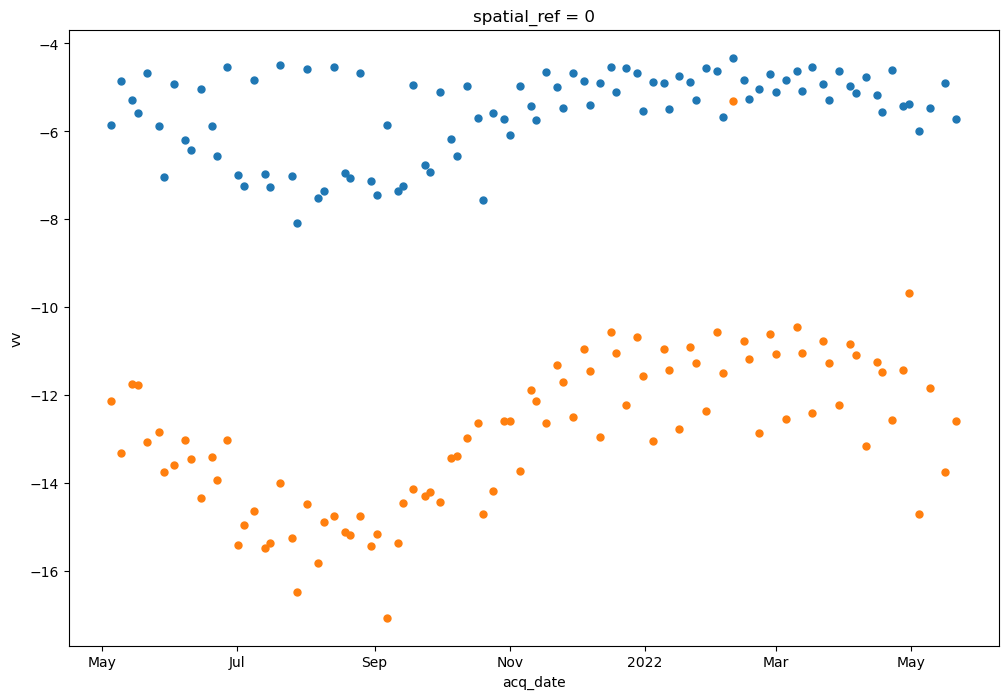

In [45]:
fig, ax = plt.subplots(figsize=(12,8));
power_to_db(vrt_full.vh.mean(dim=['x','y'])).plot(ax=ax, marker='o', linestyle='None', markersize=5)
power_to_db(vrt_full.vv.mean(dim=['x','y'])).plot(ax=ax, marker='o', linestyle='None', markersize=5);

Now what if we wanted to take a snap-shot look of backscatter at a single time step? We can still use xarray plotting methods, but this time will pass a 3-dimensional object (x,y and backscatter). We need to select a single element along the time dimension on which to call the plotting method: 

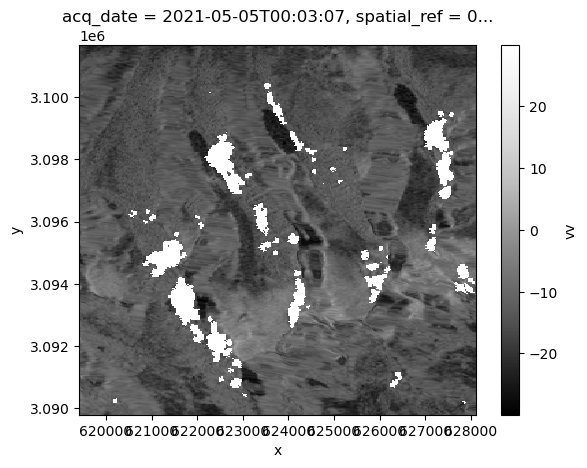

In [46]:
power_to_db(vrt_full.vv.isel(acq_date=1)).plot(cmap=plt.cm.Greys_r);

Now we have all of the same metadata attached to our xarray datacube of Sentinel-1 RTC imagery that we had using the `xr.open_mfdataset()` approach, but we've done this with much less computational expense and a chunking strategy that is more appropriate for the nature of the dataset.

We'll store this object to use it in a later notebook.

In [47]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Your code that might generate UserWarning
vrt_full.to_zarr('../data/tutorial2/s1_asf_cube.zarr',mode='w')

## Next

The next notebook on [preliminary dataset inspection](asf_inspect.ipynb) demonstrates how to explore and familiarize oneself with the dataset now that we have it read in and organized.